In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/kaggle/input/plants-diseasess/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4940 files belonging to 7 classes.


In [4]:
class_names= dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy']

In [ ]:
len(dataset)

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 6 0 5 5 0 2 5 2 2 2 3 2 0 4 6 2 3 2 6 6 2 4 0 2 2 0 3 3 0 5 1]


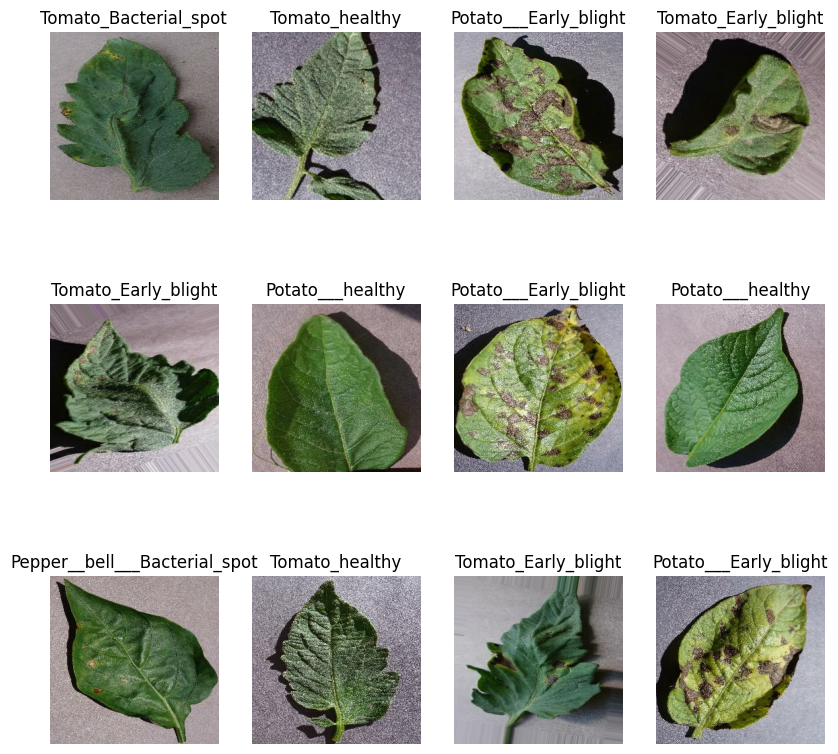

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

124.0

In [9]:
# SETTING VALUES TO TRAIN , TEST AND VALIDATE MODEL



def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

124

In [12]:
len(val_ds)

15

In [13]:
len(test_ds)

16

In [54]:
#PREPROCESSING

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

IMAGE_SIZE=256
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


In [16]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
  layers.RandomBrightness(0.1)
    
])


In [18]:
#MODEL TRAINING

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
from tensorflow.keras import regularizers


input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape[1:]),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(n_classes, activation='softmax'),
])

In [41]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,543 (724.78 KB)

 Trainable params: 185,543 (724.78 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [44]:
# Check dataset
print("Dataset loaded. Number of classes:", len(dataset.class_names))
for image_batch, labels_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)




Dataset loaded. Number of classes: 7
Image batch shape: (32, 256, 256, 3)
Labels batch shape: (32,)


In [45]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
   
)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 366ms/step - accuracy: 0.1706 - loss: 2.1671 - val_accuracy: 0.2042 - val_loss: 1.8404
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 347ms/step - accuracy: 0.2726 - loss: 1.7535 - val_accuracy: 0.2208 - val_loss: 1.9209
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 346ms/step - accuracy: 0.3280 - loss: 1.5916 - val_accuracy: 0.3854 - val_loss: 1.5103
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - accuracy: 0.3881 - loss: 1.5436 - val_accuracy: 0.4458 - val_loss: 1.3550
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - accuracy: 0.4194 - loss: 1.5205 - val_accuracy: 0.4042 - val_loss: 1.5820
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.5017 - loss: 1.3146 - val_accuracy: 0.5417 - val_loss: 1.2244
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - accuracy: 0.5278 - loss: 1.2793 - val_accuracy: 0.5729 - val_loss: 1.1082
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 341ms/step - accuracy: 0.5741 - loss: 1

In [46]:

scores = model.evaluate(test_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9385 - loss: 0.2767


In [ ]:
acc_score= 0.9385*100
print(f" Accuracy: {acc_score}")

In [ ]:
# Predict on the test dataset and generate classification report
import numpy as np
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the test dataset
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(test_labels, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(report)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Classification Report:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.90      0.83      0.86        92
       Pepper__bell___healthy       0.85      0.97      0.91        78
        Potato___Early_blight       0.90      0.96      0.93        89
             Potato___healthy       0.95      1.00      0.98        81
        Tomato_Bacterial_spot       1.00      0.85      0.92        88
          Tomato_Early_blight       0.92      0.82      0.87        80
               Tomato_healthy       0.88      1.00      0.94        68

                     accuracy                           0.91       576
                    macro avg       0.92      0.92      0.92       576
                 weighted avg       0.92      0.91      0.91       576



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


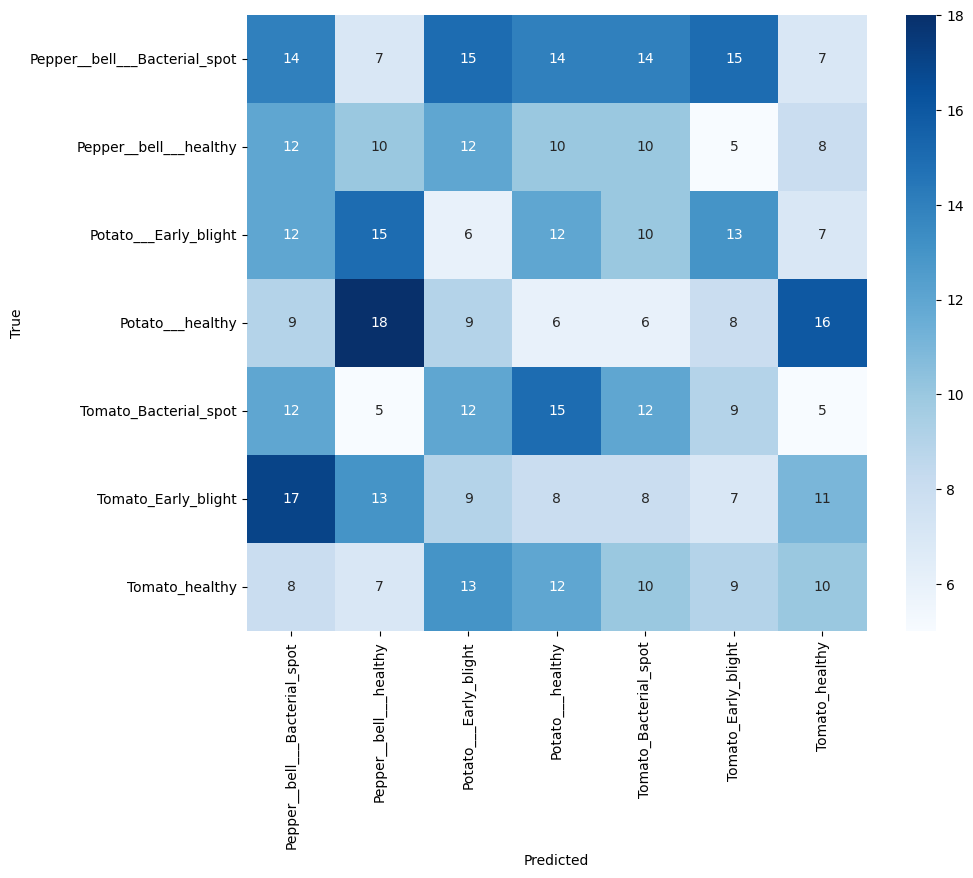

In [48]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test dataset
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the test dataset
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step


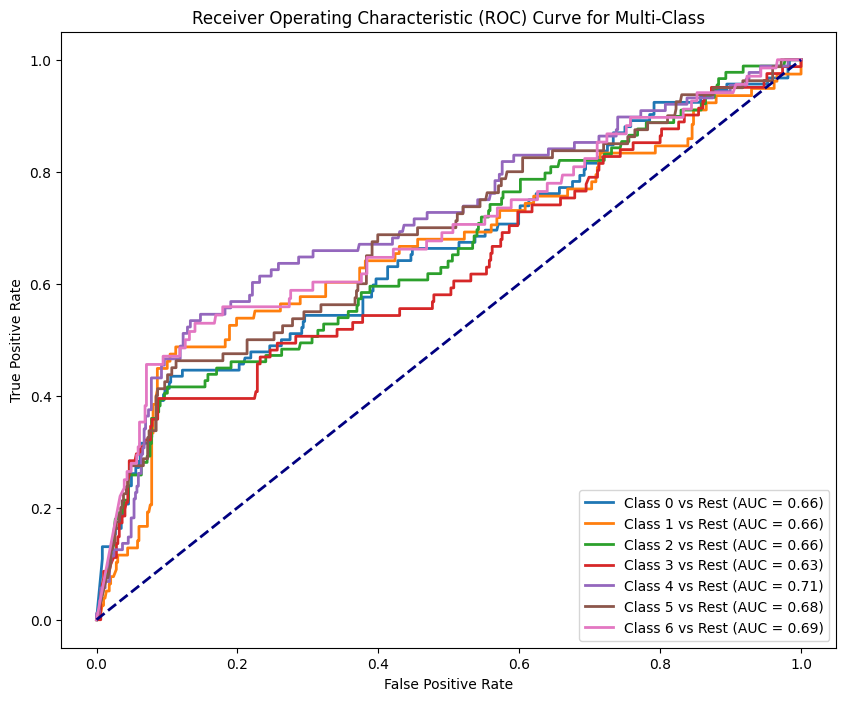

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC AUC
test_labels_binarized = label_binarize(test_labels, classes=range(n_classes))
# Predict probabilities for the test dataset
y_pred_prob = model.predict(test_ds)

# Create a plot for the ROC curve
plt.figure(figsize=(10, 8))

# Calculate and plot ROC curve for each class
for i, class_label in enumerate(range(n_classes)):
    # Calculate ROC curve for the current class
    fpr, tpr, _ = roc_curve(test_labels_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} vs Rest (AUC = {roc_auc:.2f})')

# Plot the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')

# Show the plot
plt.show()



In [70]:
#CHECKING THE EPOCHS

In [49]:
history

In [50]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 124}

In [51]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [52]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.030540704727173,
 1.721105933189392,
 1.5989813804626465,
 1.498273253440857,
 1.4693639278411865]

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

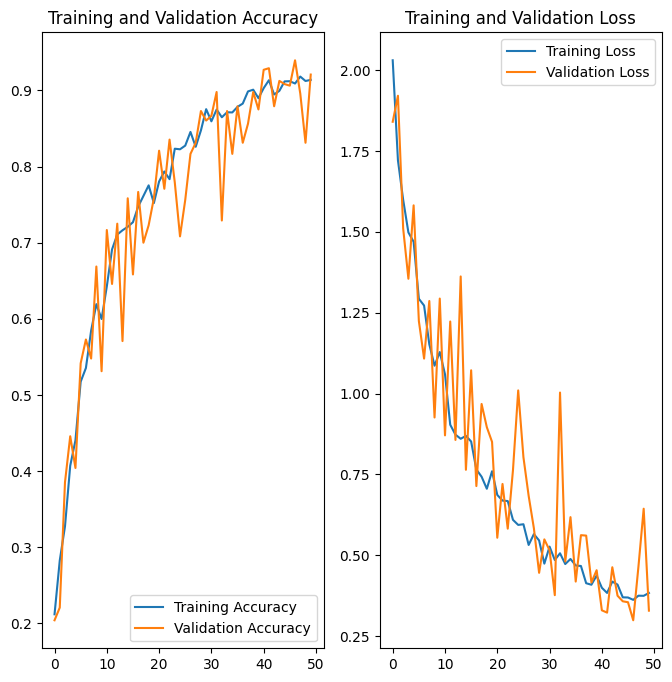

In [54]:
import matplotlib.pyplot as plt

# Number of epochs actually used in training
num_epochs = len(acc)

plt.figure(figsize=(8, 8))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
#SAMPLE PREDICTION

first image to predict
actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
predicted label: Pepper__bell___healthy


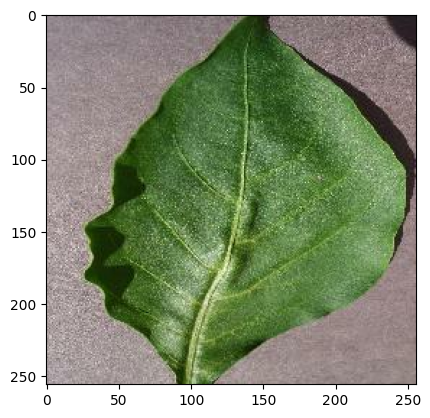

In [55]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


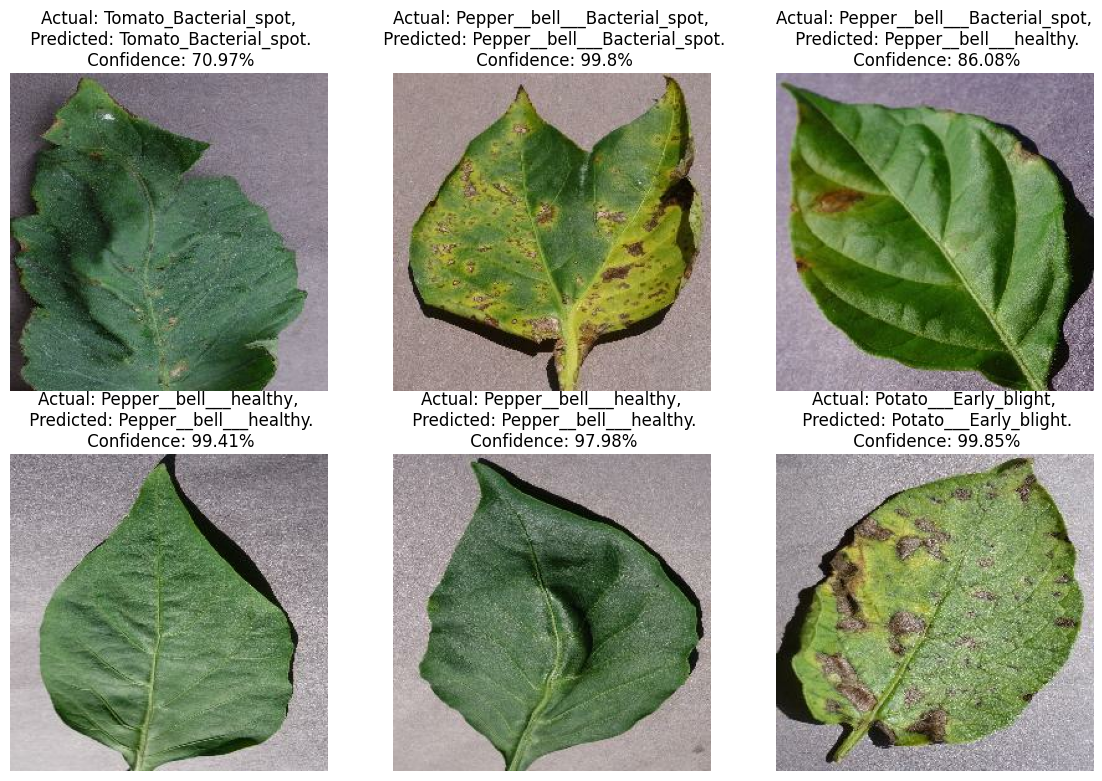

In [85]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
model.save('/kaggle/working/model.h5')
